In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
from tf_agents.agents import DdpgAgent,DqnAgent
from tf_agents.agents import ddpg,dqn
from tf_agents.utils import common
from tf_agents import networks
from tf_agents.networks import sequential
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics,tf_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

from tensorflow import Tensor,Variable
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import initializers



2022-03-01 22:11:40.336026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-01 22:11:40.336077: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



# Utils

In [3]:
class MyObserver:
    def __init__(self,verbose=False):
        self.results = []
        self.verbose = verbose
        
    def __call__(self,traj):
        obs = traj.observation
        if isinstance(obs,Tensor):
            obs = obs.numpy().copy()
        else:
            obs = obs.copy()
        self.results.append({"observation":obs,"reward":traj.reward,"traj":traj})
        if self.verbose:
            print("\tMyObserver:",traj.observation,traj.reward)
            
    def plot(self,ax=None,sample=None):
        n = len(self.results)
        x = list(range(n))
        if ax is None:
            fig,ax = plt.subplots()
        if sample is None:
            sample = len(self.results)
        sample=min(len(self.results),sample)
        results = self.results[-sample:]
        
        ax.plot([t.get("reward") for t in results])
#         plt.bar(x=x,height=[int(t.get("traj").is_last())*8 for t in results],color="g")
#         plt.bar(x=x,height=[int(t.get("traj").is_boundary())*8 for t in results],color="r")
#         plt.bar(x=x,height=[int(t.get("traj").is_first())*8 for t in results],color="k")
        return ax

In [4]:
class MyLogger:
    def __init__(self):
        self.logs = []
    def log(self,*args):
        self.logs.append(args)
    def reset(self):
        self.logs = []
    def __str__(self):
        return "\n".join(["\t".join(map(str,l)) for l in self.logs])

In [48]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [56]:
def show_policy_behaviour(environment,policy,max_iter):
        time_step = environment.reset()
        iter_ = 0.0
        results = [(None,None,time_step.observation.numpy())]
        while not time_step.is_last() and iter_<=max_iter:
            iter_+=1
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            results.append((action_step.action.numpy(),time_step.reward.numpy(),time_step.observation.numpy()))
        return results 

# PARAMETERS

In [6]:
nb_actions = 4

# Environments
## Class

In [7]:
class IArchitectEnv(py_environment.PyEnvironment):
    def __init__(self,log=False,
                 action_float=False,
                 fail_on_same=True,
                 max_iter=50,
                 rewards = {
                     "fail":-10,
                     "max_iter":-10,
                     "new_value":1,
                     "success":10
                 }):
        self._state = np.zeros((nb_actions,),dtype=np.int32)
        self._iter = 0
        self._max_iter = max_iter
        if action_float:
            self._action_spec = array_spec.BoundedArraySpec(
                shape=(), dtype=np.float32, minimum=-0.49, maximum=3.49, name='action')
        else:
            self._action_spec = array_spec.BoundedArraySpec(
                shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(self._state.shape[0],), dtype=np.int32, minimum=0, name='observation')
        self._logger = MyLogger()
        
        self._episode_ended = False
        self.log = log
        self.fail_on_same = fail_on_same
        self.rewards=rewards


    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.zeros((nb_actions,),dtype=np.int32)
        self._iter = 0
        self._episode_ended = False
#         self._logger.reset()
        return ts.restart(self._state)
#         return ts.restart(np.array([self._state], dtype=np.int32))
    

    def _step(self, action):
        """
        Remplit la action_ième case
        Termine si action déjà remplie
        """
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()
        
        self._iter += 1

        # Make sure episodes don't go on forever.
        action_ = action.round().astype(int)
        assert action_ in list(range(self._state.shape[0]))
        if self.log:
            self._logger.log(self._state,action,action_)

        if self._state[action_]==1:
            # DEJA RENSEIGNE
            reward = self.rewards["fail"]
            if self.fail_on_same:
                self._episode_ended = True    
        else:
            self._state[action_]=1
            reward = self.rewards["new_value"]
            if self._state.sum()==self._state.shape[0]:
                reward = self.rewards["success"]
                self._episode_ended = True
        
        if not self.fail_on_same and self._iter>self._max_iter:
            reward = self.rewards["max_iter"]
            self._episode_ended = True
        
        
#         print(self._episode_ended,reward,self._state)
        if not self._episode_ended:
             result = ts.transition(
                self._state, reward=reward, discount=1)
#                 np.array([self._state], dtype=np.int32), reward=penalty, discount=0.95)
        
        else:
            result = ts.termination(self._state, reward)
#             return ts.termination(np.array([self._state], dtype=np.int32), reward)
        if self.log:
            self._logger.log(result.observation,reward)
        return result


## Creation

In [8]:
environment = IArchitectEnv(log=False,action_float=False,fail_on_same=False)
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

# Agents

## DDPG

### Networks

In [9]:
observation_spec, action_spec = train_env.observation_spec(), train_env.action_spec()
actor_net = ddpg.actor_network.ActorNetwork(
    observation_spec, action_spec,
    fc_layer_params=(nb_actions*2,nb_actions*2),
)

# observation_conv_layer_params : other key words for critic_net

critic_net = ddpg.critic_network.CriticNetwork(
    (observation_spec, action_spec), joint_fc_layer_params=(nb_actions*2,nb_actions*2))

ValueError: Only float actions are supported by this network.
  In call to configurable 'ActorNetwork' (<class 'tf_agents.agents.ddpg.actor_network.ActorNetwork'>)

### Agent

In [411]:
agent = DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_net,
    critic_net,
    actor_optimizer=Adam(learning_rate=learning_rate_actor),
    critic_optimizer=Adam(learning_rate=learning_rate_critic))

#     actor_network: tf_agents.networks.Network,
#     critic_network: tf_agents.networks.Network,
#     actor_optimizer: Optional[types.Optimizer] = None,
#     critic_optimizer: Optional[types.Optimizer] = None,
#     ou_stddev: tf_agents.typing.types.Float = 1.0,
#     ou_damping: tf_agents.typing.types.Float = 1.0,
#     target_actor_network: Optional[tf_agents.networks.Network] = None,
#     target_critic_network: Optional[tf_agents.networks.Network] = None,
#     target_update_tau: tf_agents.typing.types.Float = 1.0,
#     target_update_period: tf_agents.typing.types.Int = 1,
#     dqda_clipping: Optional[types.Float] = None,
#     td_errors_loss_fn: Optional[tf_agents.typing.types.LossFn] = None,
#     gamma: tf_agents.typing.types.Float = 1.0,
#     reward_scale_factor: tf_agents.typing.types.Float = 1.0,
#     gradient_clipping: Optional[types.Float] = None,
#     debug_summaries: bool = False,
#     summarize_grads_and_vars: bool = False,
#     train_step_counter: Optional[tf.Variable] = None,
#     name: Optional[Text] = None
# )
agent.initialize()

NameError: name 'actor_net' is not defined

In [412]:
actor_net.summary()

NameError: name 'actor_net' is not defined

In [413]:
critic_net.summary()

NameError: name 'critic_net' is not defined

## DQN

### Network

#### V1

In [10]:
q_net = networks.q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params = (5,4)
)

#### v2 factory

In [11]:
def dense_layer(num_units):
    return layers.Dense(
        num_units,
        activation="relu",
        kernel_initializer=initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

def network_factory(fc_layers=(4,4)):
    q_values_layer = layers.Dense(
        nb_actions,
        activation=None,
        kernel_initializer=initializers.RandomUniform(
            minval=-0.03, maxval=0.03),
        bias_initializer=initializers.Constant(-0.2))
    q_net = sequential.Sequential([dense_layer(n) for n in fc_layers]+[q_values_layer])
    return q_net


def agent_factory(train_env,network=network_factory(),learning_rate_dqn=0.0005):
    agent = DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=network,
        optimizer=Adam(learning_rate=learning_rate_dqn),
        td_errors_loss_fn=common.element_wise_squared_loss,)
    agent.initialize()
    return agent
    

# Entrainement

## Utils

In [65]:
class Trainer:
    def __init__(self,tf_env,agent,max_length_buffer=10000):
        self.tf_env = tf_env
        self.agent = agent
        self.observer = MyObserver(verbose=False)
        self.replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
            self.agent.collect_data_spec,
            batch_size=tf_env.batch_size,
            max_length=max_length_buffer)
        self.metrics = np.array([])
        self.losses = np.array([])
        
    
    def evaluate_agent(self,num_episodes_driver=100):
        metric = tf_metrics.AverageReturnMetric()
        observers = [metric,self.observer]
        driver = dynamic_episode_driver.DynamicEpisodeDriver(
              self.tf_env, self.agent.policy, observers, num_episodes=num_episodes_driver)
        final_time_step, policy_state = driver.run()
        return metric.result().numpy()
    
    def collect_training_data(self,num_steps_driver=1000):
        dynamic_step_driver.DynamicStepDriver(
            self.tf_env,
            self.agent.collect_policy,
            observers=[self.replay_buffer.add_batch],
            num_steps=num_steps_driver).run()
        
    def train_agent(self,sample_batch_size=64,num_steps=2,num_iterations=100):
        dataset = self.replay_buffer.as_dataset(
          sample_batch_size=sample_batch_size,
          num_steps=num_steps)
        iterator = iter(dataset)

        losses = []
        for _ in range(num_iterations):
            experience, __ = next(iterator)
            losses.append(self.agent.train(experience=experience).loss.numpy())
        return losses
    
    def run(self,maximum_iterations=1000,
            num_steps_collect_driver=64,
            sample_batch_size_experience=64,
            num_iterations_train = 10,
            num_episodes_evaluate_driver=10,
            callbacks = []):
        for i in range(maximum_iterations):
            self.collect_training_data(
                num_steps_driver=num_steps_collect_driver
            )
            new_losses = self.train_agent(
                                        sample_batch_size=sample_batch_size_experience,
                                        num_iterations = num_iterations_train)
            self.losses = np.append(self.losses,
                                    new_losses)
            self.metrics = np.append(self.metrics,
                                     [self.evaluate_agent(num_episodes_driver=num_episodes_evaluate_driver)]*len(new_losses))
            for c in callbacks:
                c(i,self)   
        

## Callbacks

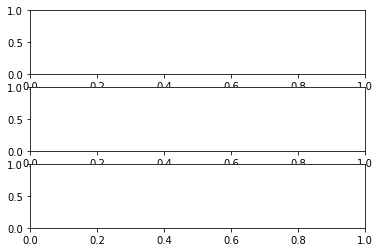

In [13]:
fig,axes = plt.subplots(3,1)
ax = axes[0]
ax2 = axes[1]
ax3 = axes[2];
def update_plot(step,trainer):
    ax.clear()
    ax2.clear()
    ax3.clear()
    ax.plot(trainer.metrics,label="metric",color="green")
    ax2.plot(trainer.losses,label="loss",color="red")
    trainer.observer.plot(ax=ax3,sample=50)        
    ax.legend()
    ax2.legend()
    clear_output(wait = True)
    display(fig)


# Runs

## With Fail

In [66]:
environment = IArchitectEnv(log=False,
                            action_float=False,
                            fail_on_same=True,
                           rewards = {
                     "fail":-10,
                     "max_iter":-10,
                     "new_value":1,
                     "success":10
                 })
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

###  "Petit" Network

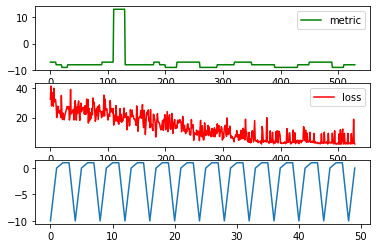

/home/maxime/.pyenv/versions/iarchitect/lib/python3.8/site-packages/tf_agents/utils/common.py:1432: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return state is not None and state is not () and state is not []
/home/maxime/.pyenv/versions/iarchitect/lib/python3.8/site-packages/tf_agents/utils/common.py:1432: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return state is not None and state is not () and state is not []


KeyboardInterrupt: 

In [67]:
trainer = Trainer(train_env,agent_factory(train_env,network=network_factory((20,20))))
trainer.run(callbacks=[update_plot],
            num_steps_collect_driver=640,
            sample_batch_size_experience = 64,
            num_iterations_train = 10
           )

## With Fail

In [ ]:
environment = IArchitectEnv(log=False,
                            action_float=False,
                            fail_on_same=True,
                           rewards = {
                     "fail":-10,
                     "max_iter":-10,
                     "new_value":1,
                     "success":10
                 })
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

###  "Gros" Network

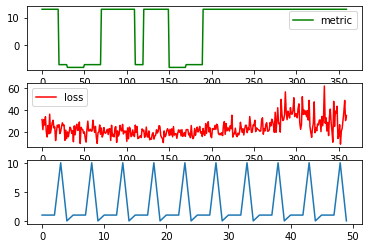

KeyboardInterrupt: 

In [27]:
trainer = Trainer(train_env,agent_factory(train_env,network=network_factory((100,50))))
trainer.run(callbacks=[update_plot],
            num_steps_collect_driver=640,
            sample_batch_size_experience = 64,
            num_iterations_train = 10
           )

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 1, 1],
       [1, 1, 1, 1]], dtype=int32)

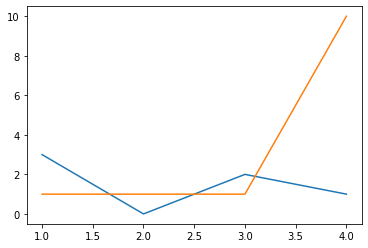

In [62]:
results = show_policy_behaviour(train_env,trainer.agent.policy,50)
plt.plot([r[0] for r in results],label="action")
plt.plot([r[1] for r in results],label="reward")
np.vstack([r[2] for r in results])

## Not Fail

In [16]:
environment = IArchitectEnv(log=False,
                            action_float=False,
                            fail_on_same=False,
                           rewards = {
                     "fail":-10,
                     "max_iter":-10,
                     "new_value":1,
                     "success":10
                 })
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

### "Petit" network

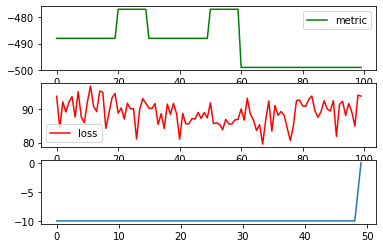

/home/maxime/.pyenv/versions/iarchitect/lib/python3.8/site-packages/tf_agents/utils/common.py:1432: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return state is not None and state is not () and state is not []
/home/maxime/.pyenv/versions/iarchitect/lib/python3.8/site-packages/tf_agents/utils/common.py:1432: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return state is not None and state is not () and state is not []


KeyboardInterrupt: 

In [17]:
trainer = Trainer(train_env,agent_factory(train_env,network=network_factory((20,20))))
trainer.run(callbacks=[update_plot],num_steps_collect_driver=1000)

## Not Fail

In [68]:
environment = IArchitectEnv(log=False,
                            action_float=False,
                            fail_on_same=False,
                           rewards = {
                     "fail":-1,
                     "max_iter":-10,
                     "new_value":5,
                     "success":100
                 })
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

### "Petit" network

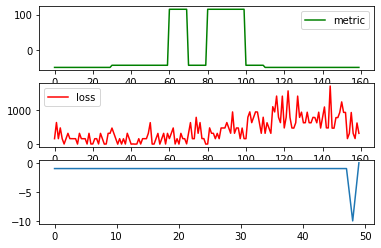

KeyboardInterrupt: 

In [19]:
trainer = Trainer(train_env,agent_factory(train_env,network=network_factory((20,20))))
trainer.run(callbacks=[update_plot],num_steps_collect_driver=1000)

### "Gros" network

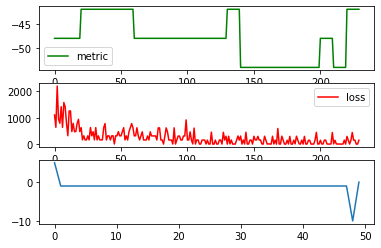

KeyboardInterrupt: 

In [69]:
trainer = Trainer(train_env,agent_factory(train_env,network=network_factory((50,50))))
trainer.run(callbacks=[update_plot],num_steps_collect_driver=1000)